In [1]:
import time
import numpy as np

# Pytorch
import torch
import torch.nn as nn

# Pytorch Lightening

# For Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# local imports
from data_loading import load_data, SNPDataModule

In [4]:
input_file = "HO_data/HO_data_filtered/HumanOrigins2067_filtered.parquet"

In [5]:
snp_data = load_data(input_file)

In [6]:
snp_data.shape

torch.Size([160858, 2067])

In [7]:
# Verification
unique_values = np.unique(snp_data)
print("Unique values after normalization:", unique_values)  # Should show [0.0, 0.5, 1.0, 9.0]

Unique values after normalization: [0.  0.5 1.  9. ]


- _LightningDataModule_

In [8]:
# initialize DataModule
snp_data_module = SNPDataModule(input_path=input_file, batch_size=256, num_workers=1)

In [9]:
# Setup Data
snp_data_module.setup()

In [10]:
# Train DataLoader
train_loader = snp_data_module.train_dataloader()

In [11]:
# Get a batch from DataLoader
sample_batch = next(iter(train_loader))

In [12]:
print("Batch Shape:", sample_batch.shape)  # Expected: (batch_size, num_markers)
print("First 5 Samples:\n", sample_batch[:5])  # Show first 5 rows

Batch Shape: torch.Size([256, 2067])
First 5 Samples:
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [13]:
x0 = sample_batch[0]
x0.shape

torch.Size([2067])

### 1. Sinusoidal Positional Embeddings

In [14]:
# import from model.py (import only corrected versions)
from model import SinusoidalPositionalEmbeddings, UniformDiscreteTimeSampler

#### _1.1 Linear Time Sampler with SinusoidalPositionalEmbeddings_

time shape: torch.Size([1000])
embedding shape: torch.Size([1000, 500])


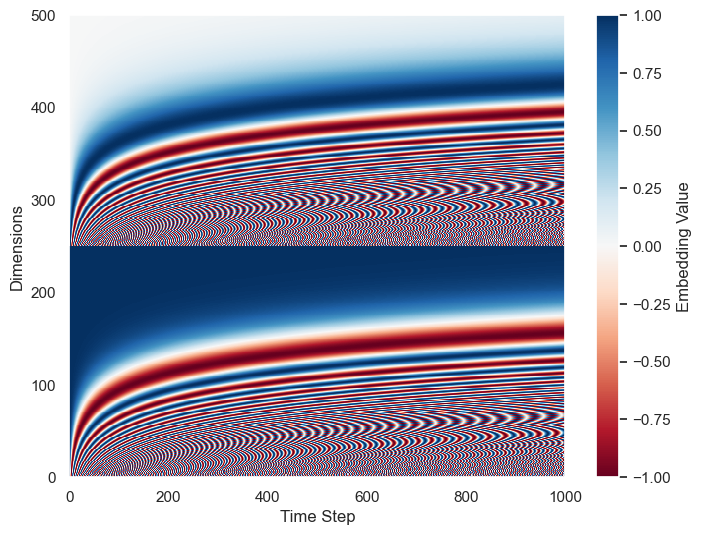

In [15]:
# Linear time sampler
timesteps = 1000  # Number of time steps
time = torch.arange(timesteps, dtype=torch.float32)  # Linear time sampler
print(f"time shape: {time.shape}")

# Sinusoidal Positional Embeddings
embedding_dim = 500  # Embedding dimensions
position_emb = SinusoidalPositionalEmbeddings(dim=embedding_dim)
emb = position_emb(time)  # Shape: [1000, 500]
print(f"embedding shape: {emb.shape}")

# Plot the embeddings
plt.figure(figsize=(8,6))
plt.pcolormesh(emb.T, cmap='RdBu', shading='auto')  # Transpose to align time on x-axis
plt.ylabel('Dimensions')
plt.xlabel('Time Step')
plt.colorbar(label="Embedding Value")
plt.show()

#### _1.2 Uniform Time Sampler with SinusoidalPositionalEmbeddings_

- By adding this Time Embedding to the hidden layer value, we can add time information to the hidden layer value.

### _2. DDPM Process_

- _Adding Gussian Noise to the Input Data (Forward Process)_

In [17]:
from model import DDPMProcess

In [18]:
# create the model
time_steps = 10
diffusion_process = DDPMProcess(num_diffusion_timesteps=time_steps, beta_start=0.00001, beta_end=0.02)
time_sampler = UniformDiscreteTimeSampler(tmin=diffusion_process.tmin, tmax=diffusion_process.tmax)

In [19]:
# x0 = sample_batch[0]  # i.e. input data, one example from a batch
t = time_sampler.sample(shape=(x0.shape[0],))
eps = torch.randn_like(x0, device=x0.device)  # Sample noise
xt = diffusion_process.sample(x0, t, eps)  # corrupted input data

In [20]:
x0

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [21]:
xt

tensor([[-0.0113, -0.0040, -0.0238,  ...,  0.0228,  0.0604, -0.0018],
        [-0.0433, -0.0152, -0.0914,  ...,  0.0875,  0.2317, -0.0071],
        [-0.0113, -0.0040, -0.0238,  ...,  0.0228,  0.0604, -0.0018],
        ...,
        [-0.0275, -0.0097, -0.0581,  ...,  0.0556,  0.1473, -0.0045],
        [-0.0275, -0.0097, -0.0581,  ...,  0.0556,  0.1473, -0.0045],
        [-0.0663, -0.0233, -0.1400,  ...,  0.1341,  0.3551, -0.0108]])

- **Visualize Diffusion (`x0` and `xt`)?**

### _Denoising Process_

- _Denoisng the Corrupted Input Data (Backward Process)_

In [22]:
from model import UNet1D

- We pass `x`, `t` to model aka `forward()` pass. Where `t` comes from time sampler.

In [23]:
# now denoise xt to recover x0 at time t
model = UNet1D(
    embedding_dim=64,       # Default embedding dimension
    dim_mults=(1, 2, 4, 8), # Feature dimension multipliers
    channels=1,             # SNP data has a single channel (also out_dim)
    with_time_emb=True,     # Includes time embeddings
    resnet_block_groups=1   # Number of groups for GroupNorm in ResNet blocks
)

In [ ]:
x0_dn = model(xt, t)

## _Diffusion Model_

In [1]:
from model import DiffusionModel, NetConfig

ImportError: cannot import name 'NetConfig' from 'model' (/home/rbashir/Semester/Thesis/GenomeDiffusion/model.py)

In [ ]:
# Final Diffusion Model
class DiffusionModel(nn.Module):
    """Diffusion model with 1D Convolutional network for SNP data."""

    def __init__(self, diffusion_process, time_sampler, net_config, data_shape):
        super(DiffusionModel, self).__init__()
        self._process = diffusion_process
        self._time_sampler = time_sampler
        self._net_config = net_config
        self._data_shape = data_shape
        self.net_fwd = Net(net_config)  # Uses Net with ResidualConv1D

    def loss(self, x0: torch.Tensor) -> torch.Tensor:
        """
        Computes MSE between true noise and predicted noise.
        The network's goal is to correctly predict noise (eps) from noisy observations.

        Args:
            x0 (torch.Tensor): Original clean input data (batch_size, seq_len)

        Returns:
            torch.Tensor: MSE loss
        """
        t = self._time_sampler.sample(shape=(x0.shape[0],))  # Sample time
        eps = torch.randn_like(x0, device=x0.device)  # Sample noise
        xt = self._process.sample(x0, t, eps)  # Corrupt the data
        net_outputs = self.net_fwd(xt, t)  # Pass through Conv1D model
        loss = torch.mean((net_outputs - eps) ** 2)  # Compute MSE loss
        return loss

    def loss_per_timesteps(
        self, x0: torch.Tensor, eps: torch.Tensor, timesteps: torch.Tensor
    ) -> torch.Tensor:
        """
        Computes loss at specific timesteps.

        Args:
            x0 (torch.Tensor): Original clean input data.
            eps (torch.Tensor): Sampled noise.
            timesteps (torch.Tensor): Selected timesteps.

        Returns:
            torch.Tensor: Loss values for each timestep.
        """
        losses = []
        for t in timesteps:
            t = int(t.item()) * torch.ones(
                (x0.shape[0],), dtype=torch.int32, device=x0.device
            )
            xt = self._process.sample(x0, t, eps)
            net_outputs = self.net_fwd(xt, t)
            loss = torch.mean((net_outputs - eps) ** 2)
            losses.append(loss)
        return torch.stack(losses)

    def _reverse_process_step(self, xt: torch.Tensor, t: int) -> torch.Tensor:
        """
        Reverse diffusion step to estimate x_{t-1} given x_t.

        Args:
            xt (torch.Tensor): Noisy input at time t.
            t (int): Current timestep.

        Returns:
            torch.Tensor: Estimated previous timestep data.
        """
        t = t * torch.ones((xt.shape[0],), dtype=torch.int32, device=xt.device)
        eps_pred = self.net_fwd(xt, t)  # Predict epsilon
        sqrt_a_t = self._process.alpha(t) / self._process.alpha(t - 1)
        inv_sqrt_a_t = 1.0 / sqrt_a_t
        beta_t = 1.0 - sqrt_a_t**2
        inv_sigma_t = 1.0 / self._process.sigma(t)
        mean = inv_sqrt_a_t * (xt - beta_t * inv_sigma_t * eps_pred)
        std = torch.sqrt(beta_t)
        z = torch.randn_like(xt)
        return mean + std * z

    def sample(self, x0, sample_size):
        """
        Samples from the learned reverse diffusion process without conditioning.

        Args:
            x0 (torch.Tensor): Initial input (not used, only for device reference).
            sample_size (int): Number of samples.

        Returns:
            torch.Tensor: Generated samples.
        """
        with torch.no_grad():
            x = torch.randn((sample_size,) + self._data_shape, device=x0.device)
            for t in range(self._process.tmax, 0, -1):
                x = self._reverse_process_step(x, t)
        return x

In [ ]:
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(6,))

In [ ]:
model